# Generate PosterLlama in desigen dataset

In [ ]:
from src.model.minigpt4 import MiniGPT4
from src.processor.blip_processors import Blip2ImageTrainProcessor,Blip2ImageEvalProcessor,DinoImageProcessor
import torch
import json
import os
from PIL import Image
from html_to_ui import get_bbox
from generation import *
#with open("log_dir/train_stage2_with_augment_dino_codellama/generated_sample/16/test_numerical.jsonl", "r") as f:
#    content = [json.loads(line) for line in f]
#with open("data/cgl_dataset/for_posternuwa/html_format_img_instruct_all_mask_and_all_condition/test_numerical.jsonl", "r") as f:
#    sample = [json.loads(line) for line in f]
device = f"cuda:{1}" if torch.cuda.is_available() else "cpu"
vit_model_name = "dino_v2"
llama_model = "models/codeLlama-7b-hf"
base_model = "log_dir/train_stage2_with_augment_dino_codellama/checkpoints/checkpoint-16/pytorch_model.bin"
model = MiniGPT4(lora_r=64,low_resource=False,vit_model = vit_model_name,llama_model = llama_model)
model.load_state_dict(torch.load(base_model,map_location="cpu"))
model = model.to(device)
model.device = device
model.half()
model.eval()

image_processor = DinoImageProcessor()

In [ ]:
from helper.global_var import *
def build_input(vals=None,text=None,canvas_width=513, canvas_height=750,task="unconditional") :
    """
        text = list of string
        vals = list of layout (category, xl,yl,xr,yr)
    """
    html_template = TEMPLATE_FORMAT.get("html_format")
    bbox_template = TEMPLATE_FORMAT.get("bbox_format")
    #instruction
    if text:
        task_instruction = TASK_INSTRUCTION.get("cgl")
        instruction = TEXT_INSTRUCTION.get(task)
        instruction = task_instruction + instruction
        
        t = []
        for te in text:
            t.append(te)
        text = " & ".join(text)
        
    else:
        task_instruction = TASK_INSTRUCTION.get("cgl")
        instruction = INSTRUCTION.get(task)
        instruction = task_instruction + instruction
    MASK= "<M>"
    def _build_rect(category='background', x=None, y=None, w=None, h=None):
        
        if not x:
            x="<M>"
        if not y:
            y="<M>"
        if not w:
            w="<M>"
        if not h:
            h = "<M>"
        
        rect = bbox_template.format(c=category, x=x, y=y, w=w, h=h)
        return rect #f'<rect data-category=\"{category}\", x=\"{x}\", y=\"{y}\", width=\"{w}\", height=\"{h}\"/>\n'
    
    
    contents = []
    if vals:
        for category, x, y, w, h in vals :
            contents.append(_build_rect(category, x, y, w, h))
            content = "\n".join(contents)
    else:
        content = ""
    bbox_html = html_template.format(W=canvas_width, H=canvas_height, content = content)
    #str_output = f'{instruction} (in html format):\n###bbox html:  <body> <svg width=\"{canvas_width}\" height=\"{canvas_height}\">{rects} </svg> </body>'
    if text:
        str_output = instruction.format(text= text, bbox_html = bbox_html)
    else:
        str_output = instruction.format(bbox_html = bbox_html)
    return str_output
text = None#["ECCV 2024","PosterLlama"]
input = build_input(None,text)

In [ ]:
import matplotlib.pyplot as plt
DATASET_COLOR = {
    1: '#929F29',   
    2: '#1FA39A',  
    3: '#987FF2',      
    4: '#F56881',    
    5: "#0000FF"      
}
def sort_key(x):
    if x[0] == 3:
        return -1
    else:
        return x[0]
img_paths = os.listdir("/data1/poong/tjfwownd/desigen/data/processed_images/images")
output_file = f"log_dir/Paper_samples/Generated_Sample_desigen/PosterLlama"
os.makedirs(os.path.join(output_file,"generated_sample"),exist_ok=True)

#images = []
#processed_images=[]
#for path in img_paths:
#    img = Image.open(os.path.join("/data1/poong/tjfwownd/desigen/data/processed_images/images",path)).resize((513,750))
#    images.append(img)
#    processed_images.append(image_processor(img))
#    
#processed_images = torch.stack(processed_images,dim=0)

uncond_inst = 'I want to generate layout in poster design format.plaese generate the layout html according to the image I provide (in html format):\n###bbox html: <body> <svg width="513" height="750">  </svg> </body> '
inst = [uncond_inst]*len(img_paths)
#inst = [input]*len(img_paths)
boxx = []
clx = []
imgs = []
save_img=True
from tqdm import tqdm
for path in tqdm(img_paths):
    img = Image.open(os.path.join("/data1/poong/tjfwownd/desigen/data/processed_images/images",path)).resize((513,750))
    processed_images = image_processor(img).unsqueeze(0)
    inst = [uncond_inst]
    
    with torch.no_grad():
        with torch.autocast(device_type="cuda"):
            samp = model.generate(processed_images, inst,max_new_tokens=512,do_sample=False,temperature=0.6,top_p=0.9)
    
    bboxes,clses = get_bbox(samp[0])
    
    if save_img:
        drawbbox = []
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            x2 += x1
            y2 += y1
            bbox  = [x1, y1, x2, y2]
            drawbbox.append(np.array(bbox))
        drawn_outline = img.copy()
        drawn_fill = img.copy()
        draw_ol = ImageDraw.ImageDraw(drawn_outline)
        draw_f = ImageDraw.ImageDraw(drawn_fill)

        sorted_pairs = sorted(zip(clses, drawbbox), key=sort_key)
        sorted_classes, sorted_bboxes = zip(*sorted_pairs)

        clses = list(sorted_classes)
        drawbbox = list(sorted_bboxes)

        for b,l in zip(drawbbox,clses):
            draw_ol.rectangle([b[0],b[1],b[2],b[3]], outline=DATASET_COLOR[l], width=2)
        for b,l in zip(drawbbox,clses):
            draw_f.rectangle([b[0],b[1],b[2],b[3]], fill=DATASET_COLOR[l])
        drawn_outline = drawn_outline.convert("RGBA")
        drawn_fill = drawn_fill.convert("RGBA")

        drawn_fill.putalpha(int(256 * 0.4))
        img = Image.alpha_composite(drawn_outline, drawn_fill)
        #layout_images.append(img)
        #display(img)
        img.convert("RGB").save(os.path.join(output_file,"generated_sample",path))

    boxx.append(np.array(drawbbox).tolist())
    clx.append(np.array(clses).tolist())
    imgs.append(path)

if  save_img:
    display(img)
    
with open(os.path.join(output_file,"box.json"), "w") as f:
    json.dump(boxx,f,indent=2)

with open(os.path.join(output_file,"clses.json"),"w") as f:
    json.dump(clx,f,indent=2)

with open(os.path.join(output_file,"text_order.json"),"w") as f:
    json.dump(imgs,f,indent=2)

# DS-GAN

In [ ]:
import json
from PIL import Image, ImageDraw
import os
import numpy as np
def sort_key(x):
    if x[0] == 3:
        return -1
    else:
        return x[0]
#DATASET_COLOR = {
#    1: '#929F29', #"#FF0000",       # 빨 , logo 
#    2: '#1FA39A', #"#FFA500",       # 주 , text
#    3: '#987FF2', #"#FFFF00",       # 노 , underlay
#    4: '#F56881', #"#008000"        # 초 , emblishment
#    5: "#0000FF"        # 파
#}

DATASET_COLOR = {
    1: '#929F29', #"#FF0000",       # 빨 , logo 
    2: '#1FA39A', #"#FFA500",       # 주 , text
    3: '#987FF2', #"#FFFF00",       # 노 , underlay
    4: '#F56881', #"#008000"        # 초 , emblishment
    5: "#0000FF"        # 파
} # for DSGAN


box_gt ="/data1/poong/tjfwownd/PosterNUWA/log_dir/Paper_samples/Generated_Sample_desigen/DS-GAN/box.json"
clses_gt = "/data1/poong/tjfwownd/PosterNUWA/log_dir/Paper_samples/Generated_Sample_desigen/DS-GAN/clses.json"
text_order = "/data1/poong/tjfwownd/PosterNUWA/log_dir/Paper_samples/Generated_Sample_desigen/DS-GAN/test_order.json"


with open(box_gt,"r") as f:
    box = json.load(f)
with open(clses_gt,"r") as f:
    cls = json.load(f)

with open(text_order,"r") as f:
    order = json.load(f)

img_dir = "/data1/poong/tjfwownd/desigen/data/processed_images/images"
output_file = f"/data1/poong/tjfwownd/PosterNUWA/log_dir/Paper_samples/Generated_Sample_desigen/DS-GAN"
os.makedirs(os.path.join(output_file,"generated_sample"),exist_ok=True)

save_img= True
for index in range(len(box)):
    boxes = box[index]
    clses = cls[index]

    img_path = order[index]
    
    drawbbox = boxes
    if save_img:
        img = Image.open(os.path.join(img_dir,img_path))
        drawn_outline = img.copy()
        drawn_fill = img.copy()
        draw_ol = ImageDraw.ImageDraw(drawn_outline)
        draw_f = ImageDraw.ImageDraw(drawn_fill)
        
        sorted_pairs = sorted(zip(clses, drawbbox), key=sort_key)
        sorted_classes, sorted_bboxes = zip(*sorted_pairs)

        clses = list(sorted_classes)
        drawbbox = list(sorted_bboxes)
        
        for b,l in zip(drawbbox,clses):
            draw_ol.rectangle([b[0],b[1],b[2],b[3]], outline=DATASET_COLOR[l], width=2)
        for b,l in zip(drawbbox,clses):
            draw_f.rectangle([b[0],b[1],b[2],b[3]], fill=DATASET_COLOR[l])
        
        drawn_outline = drawn_outline.convert("RGBA")
        drawn_fill = drawn_fill.convert("RGBA")
        drawn_fill.putalpha(int(256 * 0.4))
        img = Image.alpha_composite(drawn_outline, drawn_fill).convert("RGB")
        img.save(os.path.join(output_file,"generated_sample",img_path.replace("png","jpg")))

display(img)

In [11]:
import json
from PIL import Image, ImageDraw
import os
import numpy as np
def sort_key(x):
    if x[0] == 3:
        return -1
    else:
        return x[0]
#DATASET_COLOR = {
#    1: '#929F29', #"#FF0000",       # 빨 , logo 
#    2: '#1FA39A', #"#FFA500",       # 주 , text
#    3: '#987FF2', #"#FFFF00",       # 노 , underlay
#    4: '#F56881', #"#008000"        # 초 , emblishment
#    5: "#0000FF"        # 파
#}

DATASET_COLOR = {
    1: '#929F29', #"#FF0000",       # 빨 , logo 
    2: '#1FA39A', #"#FFA500",       # 주 , text
    3: '#987FF2', #"#FFFF00",       # 노 , underlay
    4: '#F56881', #"#008000"        # 초 , emblishment
    5: "#0000FF"        # 파
} # for DSGAN


box_gt ="/data1/poong/tjfwownd/PosterNUWA/log_dir/Paper_samples/Generated_Sample_yinhe/DS-GAN/box.json"
clses_gt = "/data1/poong/tjfwownd/PosterNUWA/log_dir/Paper_samples/Generated_Sample_yinhe/DS-GAN/clses.json"
text_order = "/data1/poong/tjfwownd/PosterNUWA/log_dir/Paper_samples/Generated_Sample_yinhe/DS-GAN/test_order.json"


with open(box_gt,"r") as f:
    box = json.load(f)
with open(clses_gt,"r") as f:
    cls = json.load(f)

with open(text_order,"r") as f:
    order = json.load(f)

img_dir = "/data1/poong/tjfwownd/PosterNUWA/data/cgl_dataset/yinhe_imgs"
output_file = f"/data1/poong/tjfwownd/PosterNUWA/log_dir/Paper_samples/Generated_Sample_yinhe/DS-GAN"
os.makedirs(os.path.join(output_file,"generated_sample"),exist_ok=True)

save_img= True
for index in range(len(box)):
    boxes = box[index]
    clses = cls[index]

    img_path = order[index]
    
    drawbbox = boxes
    if save_img:
        img = Image.open(os.path.join(img_dir,img_path)).resize((513,750))
        drawn_outline = img.copy()
        drawn_fill = img.copy()
        draw_ol = ImageDraw.ImageDraw(drawn_outline)
        draw_f = ImageDraw.ImageDraw(drawn_fill)
        
        sorted_pairs = sorted(zip(clses, drawbbox), key=sort_key)
        sorted_classes, sorted_bboxes = zip(*sorted_pairs)

        clses = list(sorted_classes)
        drawbbox = list(sorted_bboxes)
        
        for b,l in zip(drawbbox,clses):
            draw_ol.rectangle([b[0],b[1],b[2],b[3]], outline=DATASET_COLOR[l], width=2)
        for b,l in zip(drawbbox,clses):
            draw_f.rectangle([b[0],b[1],b[2],b[3]], fill=DATASET_COLOR[l])
        
        drawn_outline = drawn_outline.convert("RGBA")
        drawn_fill = drawn_fill.convert("RGBA")
        drawn_fill.putalpha(int(256 * 0.4))
        img = Image.alpha_composite(drawn_outline, drawn_fill).convert("RGB")
        img.save(os.path.join(output_file,"generated_sample",img_path.replace("png","jpg")))

display(img)

IsADirectoryError: [Errno 21] Is a directory: '/data1/poong/tjfwownd/PosterNUWA/data/cgl_dataset/yinhe_imgs/@eaDir'

# RADM

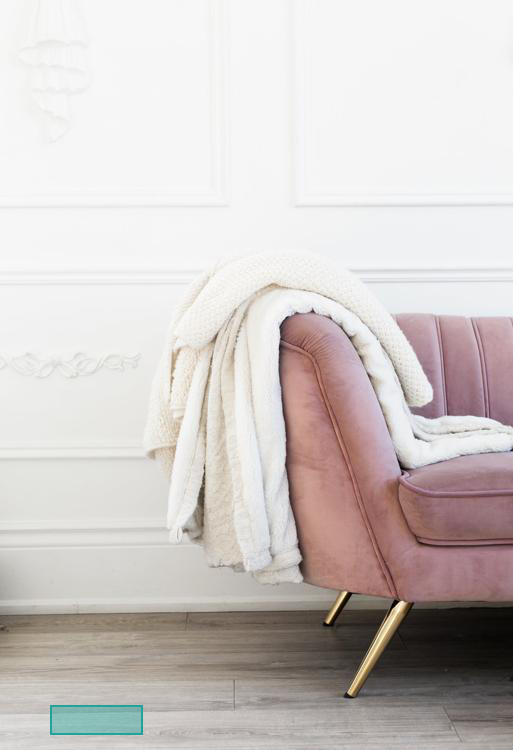

In [1]:
import json
from PIL import Image, ImageDraw
import os
import numpy as np
with open("/data1/poong/tjfwownd/PosterNUWA/log_dir/Paper_samples/Generated_Sample_desigen/RADM/coco_instances_results.json","r") as f:
    radm = json.load(f)
    
with open("/data1/poong/tjfwownd/desigen/data/processed_images/annotations/test.json" , "r") as f:
    test = json.load(f)

DATASET_COLOR = {
    1: '#929F29', #"#FF0000",       # 빨 , logo 
    2: '#1FA39A', #"#FFA500",       # 주 , text
    3: '#987FF2', #"#FFFF00",       # 노 , underlay
    4: '#F56881', #"#008000"        # 초 , emblishment
    5: "#0000FF"        # 파
}
#DATASET_COLOR = {
#    1:  "#FF0000",       # 빨 , logo 
#    2:  "#FFA500",       # 주 , text
#    3:  "#FFFF00",       # 노 , underlay
#    4:  "#008000",        # 초 , emblishment
#    5: "#0000FF"
#}

res={}
for ann in radm:
    if ann['image_id'] not in res:
        res[ann['image_id']]=[ann]
    else:
        res[ann['image_id']].append(ann)
res = list(res.values())

img_path = "/data1/poong/tjfwownd/desigen/data/processed_images/images"
output_file = f"/data1/poong/tjfwownd/PosterNUWA/log_dir/Paper_samples/Generated_Sample_desigen/RADM"

os.makedirs(os.path.join(output_file,"generated_sample"),exist_ok=True)
boxx = []
clx = []
imgs = []
save_img = True

for index in range(len(res)):
    sample_path = test['images'][index]['file_name']
    sam = res[index]
    
    bboxes = [sa['bbox'] for sa in sam] 
    clses = [sa['category_id'] for sa in sam]
    drawbbox = []
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        x2 += x1
        y2 += y1
        bbox  = [x1, y1, x2, y2] #[x1*w_m, y1*h_m, x2*w_m, y2*h_m]
        drawbbox.append(np.array(bbox))
    
    if save_img:
        img = Image.open(os.path.join(img_path,sample_path)).resize([513,750])
        drawn_outline = img.copy()
        drawn_fill = img.copy()
        draw_ol = ImageDraw.ImageDraw(drawn_outline)
        draw_f = ImageDraw.ImageDraw(drawn_fill)
        
        for b,l in zip(drawbbox,clses):
            draw_ol.rectangle([b[0],b[1],b[2],b[3]], outline=DATASET_COLOR[l], width=2)
        for b,l in zip(drawbbox,clses):
            draw_f.rectangle([b[0],b[1],b[2],b[3]], fill=DATASET_COLOR[l])
        
        drawn_outline = drawn_outline.convert("RGBA")
        drawn_fill = drawn_fill.convert("RGBA")
        drawn_fill.putalpha(int(256 * 0.4))
        img = Image.alpha_composite(drawn_outline, drawn_fill)
        
        img.save(os.path.join(output_file,"generated_sample",sample_path.replace("jpg","png")))
        
    #display(img)
    boxx.append(np.array(drawbbox).tolist())
    clx.append(np.array(clses).tolist())
    imgs.append(sample_path.replace("jpg","png"))


if  save_img:
    display(img)
    
with open(os.path.join(output_file,"box.json"), "w") as f:
    json.dump(boxx,f,indent=2)

with open(os.path.join(output_file,"clses.json"),"w") as f:
    json.dump(clx,f,indent=2)

with open(os.path.join(output_file,"text_order.json"),"w") as f:
    json.dump(imgs,f,indent=2)

In [ ]:
len(res)

# LayoutPrompter CGL

In [ ]:
import pickle
import os
from PIL import Image, ImageDraw
import os
import csv
import numpy as np
from html_to_ui import get_bbox,draw_bbox
import json
import glob
DATASET_COLOR = {
    1: '#929F29', #"#FF0000",       # 빨 , logo 
    2: '#1FA39A', #"#FFA500",       # 주 , text
    3: '#987FF2', #"#FFFF00",       # 노 , underlay
    4: '#F56881', #"#008000"        # 초 , emblishment
    5: "#0000FF"        # 파
}
def sort_key(x):
    if x[0] == 3:
        return -1
    else:
        return x[0]
si = 1
dir_name = "/nas2/lait/1000_Members/proinit/layout-generation/exp-desigen/cgl/exp-desigen"
output_file = f"/data1/poong/tjfwownd/PosterNUWA/log_dir/Paper_samples/Generated_Sample_desigen/LayoutPrompter/CGL"
samples_dirs = os.listdir(dir_name)


sm_dir = '/nas2/lait/1000_Members/tjfwownd/desigen/data/processed_images/images'


os.makedirs(os.path.join(output_file,"generated_sample"),exist_ok=True)

boxx = []
clx = []
imgs = []
save_img = True
for si in range(5):
    os.makedirs(os.path.join(output_file,str(si)),exist_ok=True)
    for index in range(len(samples_dirs)):
        with open(os.path.join(dir_name,samples_dirs[index]), 'rb') as f :
            data = pickle.load(f)


        img_name = glob.glob(os.path.join(sm_dir, '*.jpg'))[list(data.keys())[0]]

        sample = data[list(data.keys())[0]][1]
        bboxes = sample[si][1]
        clses = np.array(sample[si][0])
        drawbbox = []
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            x2 += x1
            y2 += y1
            x1, x2 = x1 * 513, x2 * 513
            y1, y2 = y1 * 750, y2 * 750
            bbox  = [x1, y1, x2, y2]
            drawbbox.append(np.array(bbox))
        if si==0:
            if save_img:
                img = Image.open(os.path.join("data/cgl_dataset/cgl_inpainting_all",img_name))
                drawn_outline = img.copy()
                drawn_fill = img.copy()
                draw_ol = ImageDraw.ImageDraw(drawn_outline)
                draw_f = ImageDraw.ImageDraw(drawn_fill)
                
                sorted_pairs = sorted(zip(clses, drawbbox), key=sort_key)
                sorted_classes, sorted_bboxes = zip(*sorted_pairs)

                clses = list(sorted_classes)
                drawbbox = list(sorted_bboxes)
                
                for b,l in zip(drawbbox,clses):
                    draw_ol.rectangle([b[0],b[1],b[2],b[3]], outline=DATASET_COLOR[l], width=2)
                for b,l in zip(drawbbox,clses):
                    draw_f.rectangle([b[0],b[1],b[2],b[3]], fill=DATASET_COLOR[l])

                drawn_outline = drawn_outline.convert("RGBA")
                drawn_fill = drawn_fill.convert("RGBA")
                drawn_fill.putalpha(int(256 * 0.5))
                img = Image.alpha_composite(drawn_outline, drawn_fill)
                img.save(os.path.join(output_file,"generated_sample",img_name.split("/")[-1].replace("jpg","png")))
        boxx.append(np.array(drawbbox).tolist())
        clx.append(np.array(clses).tolist())
        imgs.append(img_name.split("/")[-1].replace("jpg","png"))

    print(si)



    if  save_img:
        display(img)

    with open(os.path.join(output_file,str(si),"box.json"), "w") as f:
        json.dump(boxx,f,indent=2)

    with open(os.path.join(output_file,str(si),"clses.json"),"w") as f:
        json.dump(clx,f,indent=2)

    with open(os.path.join(output_file,str(si),"text_order.json"),"w") as f:
        json.dump(imgs,f,indent=2)


# LayoutPrompter PKU

In [ ]:
import pickle
import os
from PIL import Image, ImageDraw
import os
import csv
import numpy as np
from html_to_ui import get_bbox,draw_bbox
import json
import glob
DATASET_COLOR = {
    1: '#929F29', #"#FF0000",       # 빨 , logo 
    2: '#1FA39A', #"#FFA500",       # 주 , text
    3: '#987FF2', #"#FFFF00",       # 노 , underlay
    4: '#F56881', #"#008000"        # 초 , emblishment
    5: "#0000FF"        # 파
}
def sort_key(x):
    if x[0] == 3:
        return -1
    else:
        return x[0]
si = 1
dir_name = "/nas2/lait/1000_Members/proinit/layout-generation/exp-desigen/pku/exp-desigen"
output_file = f"/data1/poong/tjfwownd/PosterNUWA/log_dir/Paper_samples/Generated_Sample_desigen/LayoutPrompter/PKU"
samples_dirs = os.listdir(dir_name)


sm_dir = '/nas2/lait/1000_Members/tjfwownd/desigen/data/processed_images/images'


os.makedirs(os.path.join(output_file,"generated_sample"),exist_ok=True)

boxx = []
clx = []
imgs = []
save_img = True
for si in range(5):
    os.makedirs(os.path.join(output_file,str(si)),exist_ok=True)
    for index in range(len(samples_dirs)):
        with open(os.path.join(dir_name,samples_dirs[index]), 'rb') as f :
            data = pickle.load(f)


        img_name = glob.glob(os.path.join(sm_dir, '*.jpg'))[list(data.keys())[0]]

        sample = data[list(data.keys())[0]][1]
        bboxes = sample[si][1]
        clses = np.array(sample[si][0])
        drawbbox = []
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            x2 += x1
            y2 += y1
            x1, x2 = x1 * 513, x2 * 513
            y1, y2 = y1 * 750, y2 * 750
            bbox  = [x1, y1, x2, y2]
            drawbbox.append(np.array(bbox))
        if si==0:
            if save_img:
                img = Image.open(os.path.join("data/cgl_dataset/cgl_inpainting_all",img_name))
                drawn_outline = img.copy()
                drawn_fill = img.copy()
                draw_ol = ImageDraw.ImageDraw(drawn_outline)
                draw_f = ImageDraw.ImageDraw(drawn_fill)
                
                sorted_pairs = sorted(zip(clses, drawbbox), key=sort_key)
                sorted_classes, sorted_bboxes = zip(*sorted_pairs)

                clses = list(sorted_classes)
                drawbbox = list(sorted_bboxes)
                clses = [2 if x == 1 else (1 if x == 2 else x) for x in clses]
                for b,l in zip(drawbbox,clses):
                    draw_ol.rectangle([b[0],b[1],b[2],b[3]], outline=DATASET_COLOR[l], width=2)
                for b,l in zip(drawbbox,clses):
                    draw_f.rectangle([b[0],b[1],b[2],b[3]], fill=DATASET_COLOR[l])

                drawn_outline = drawn_outline.convert("RGBA")
                drawn_fill = drawn_fill.convert("RGBA")
                drawn_fill.putalpha(int(256 * 0.5))
                img = Image.alpha_composite(drawn_outline, drawn_fill)
                img.save(os.path.join(output_file,"generated_sample",img_name.split("/")[-1].replace("jpg","png")))
        boxx.append(np.array(drawbbox).tolist())
        clx.append(np.array(clses).tolist())
        imgs.append(img_name.split("/")[-1].replace("jpg","png"))

    print(si)



    if  save_img:
        display(img)

    with open(os.path.join(output_file,str(si),"box.json"), "w") as f:
        json.dump(boxx,f,indent=2)

    with open(os.path.join(output_file,str(si),"clses.json"),"w") as f:
        json.dump(clx,f,indent=2)

    with open(os.path.join(output_file,str(si),"text_order.json"),"w") as f:
        json.dump(imgs,f,indent=2)
